<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import f1_score
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from scipy import sparse
import time

# random seed
seed = 0

/content
Cloning into 'Self_Love_App'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 111 (delta 62), reused 23 (delta 11), pack-reused 0
Receiving objects: 100% (111/111), 528.27 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Self_Love_App
     |████████████████████████████████| 92kB 5.5MB/s 


# Data Preparation

In [2]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df = data_cleaning(df)
df = data_encoding(df)
df_norm = data_normalization(df)
df_norm

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,...,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Badminton,Playing computer games,Playing board games,Reading,Team sports,Exercising,Writing,Dancing,Gardening,Painting,Cooking,Singing,Puzzles,Collecting,Fishing,Watching movies,Watching TV series,Sleeping,Photography and Videography,Listening to music,Crocheting,Playing a musical instrument
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.25,0.50,0.75,0.75,0.75,0.666667,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.75,0.75,0.75

In [3]:
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Male
1 What is your current occupation?_Retired
2 What is your current occupation?_Unemployed
3 What is your current occupation?_University student
4 What boosts your confidence ? _By leading others to success
5 What boosts your confidence ? _Get the most/ special attention among the members
6 What boosts your confidence ? _When someone acknowledges you
7 What boosts your confidence ? _When you accomplish a project
8 I prefer to spend my money on...._Food
9 I prefer to spend my money on...._Home Improvements
10 I prefer to spend my money on...._The latest fashion
11 I prefer to spend my money on...._The latest technology
12 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
13 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
14 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
15 How do you organize your thoughts? Please pick whichever is 

In [4]:
x = df_norm.iloc[:, :64]
y = df_norm.iloc[:, 64:]
x.describe()

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,1

In [5]:
# check the distribution of the hobbies
(y.sum()/y.sum().sum() * 100).sort_values(ascending=False)

Reading                         15.720524
Playing computer games          11.790393
Exercising                      10.334789
Singing                          8.151383
Cooking                          7.714702
Badminton                        6.841339
Painting                         5.385735
Writing                          5.240175
Playing board games              5.240175
Dancing                          5.094614
Puzzles                          4.657933
Team sports                      3.493450
Gardening                        1.746725
Watching TV series               1.310044
Sleeping                         1.164483
Watching movies                  0.873362
Fishing                          0.582242
Listening to music               0.582242
Photography and Videography      0.436681
Playing a musical instrument     0.436681
Crocheting                       0.145560
dtype: float64

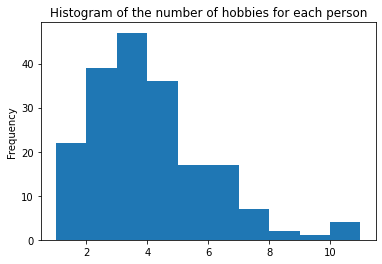

In [6]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

In [7]:
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 153
Number of test dataset: 39


# Models

In [8]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Tree", ExtraTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius_Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain,
    # "Label_Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct_Random k-labtest" : RakelD,
    "Overlapping_Random_k-labtest" : RakelO,
    "Label_Space_Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity_Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [9]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [10]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.3797128419258336
Binary_Relevance_kNN_B 0.024161168650987025
Multi-Label_KNN 0.3797128419258336
ARAM_Neural_Network 0.38328339701270087
Twin_SVM 0.40962021085730516


### Problem Transformation

In [11]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
# Random forest and ExtraTrees takes about 20 minutes each, if dw to wait, can just comment out these 2 algo in the dict above
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Decision_Tree 0.3466201485663065
Binary_Relevance_Extra_Tree 0.3278144601610964
Binary_Relevance_Extra_Trees 0.36483236926276963
Binary_Relevance_Random_Forest 0.318010826755701
Binary_Relevance_MLP 0.37012531934585763
Binary_Relevance_Ridge 0.33288658418749295
Classifier_Chain_Decision_Tree 0.350141354705678
Classifier_Chain_Extra_Tree 0.3346527904153152
Classifier_Chain_Extra_Trees 0.34737551856163906
Classifier_Chain_Random_Forest 0.3142893840428285
Classifier_Chain_MLP 0.35026773649160603
Classifier_Chain_Ridge 0.30882782270035275


### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [12]:
for model_name, model in results.items():
  y_pred = model.predict(x_test)
  score = f1_score(y_test, y_pred, average='micro')
  print(model_name, score)

Binary_Relevance_kNN_A 0.35424354243542433
Binary_Relevance_kNN_B 0.02952029520295203
Multi-Label_KNN 0.35424354243542433
ARAM_Neural_Network 0.3283582089552239
Twin_SVM 0.3569794050343249
Binary_Relevance_Decision_Tree 0.34716981132075475
Binary_Relevance_Extra_Tree 0.30824372759856633
Binary_Relevance_Extra_Trees 0.2765957446808511
Binary_Relevance_Random_Forest 0.26519337016574585
Binary_Relevance_MLP 0.31896551724137934
Binary_Relevance_Ridge 0.29
Classifier_Chain_Decision_Tree 0.34558823529411764
Classifier_Chain_Extra_Tree 0.213953488372093
Classifier_Chain_Extra_Trees 0.31016042780748665
Classifier_Chain_Random_Forest 0.24000000000000002
Classifier_Chain_MLP 0.29493087557603687
Classifier_Chain_Ridge 0.26737967914438504
